## Background

In this notebook I'll calculate the Flesch Kincaid reading grade level for the TinyStories dataset.

This is part of a larger project I'm working on where my goal is to train the TinyInstruct-33M model on a simplified, lower reading level version of the `financial_phrasebank` dataset. I'm experimenting with using phi-3 to simplify the sentences in the original `financial_phrasebank` dataset using language appropriate for low reading grade levels. To establish a baseline of what reading level of text TinyInstruct-33M is capable of understanding, I'll measure the reading level across the TinyStories dataset in this notebook using the `textstat` library.

## Reading Grade Level of a Sample Story

In [ ]:
!pip install textstat -qq
!pip install datasets -qq

In [ ]:
from datasets import load_dataset
import numpy as np
import textstat

ds = load_dataset("roneneldan/TinyStories")

According to the `textstat` library, the following story has a reading grade level of 3.8.

In [3]:
text = ds['train'][0]['text']
text

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [4]:
textstat.flesch_kincaid_grade(text)

3.8

I checked a few online Flesch-Kincaid calculators and got a wide variety of results:

- [goodcalculators.com](https://goodcalculators.com/flesch-kincaid-calculator/): 4.5
- [serpninja.io](https://serpninja.io/tools/flesch-kincaid-calculator/): 5.49
- [charactercalculator.com](https://charactercalculator.com/flesch-reading-ease/): 6.76
- [online-utility.org](https://www.online-utility.org/english/readability_test_and_improve.jsp): 5.4

Why so much variability? I'll take a closer look at the Flesch-Kincaid reading grade level formula from the [Wiki page](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level):

$$0.39\big(\frac{\text{total words}}{\text{total sentences}}\big) + 11.8\big(\frac{\text{total syllables}}{\text{total words}}\big) - 15.59$$



Counting by hand, there are a 134 total words, 9 total sentences and 169 syllables. Plugging this into the formula, you get a reading level of 5.09.

In [5]:
def fk_reading_level(w, s, sy):
  return 0.39*(w/s) + 11.8*(sy/w) - 15.59

In [6]:
fk_reading_level(134, 9, 169)

5.098756218905475

I'm guessing that one source of variability is how you count sentences. For example, if I choose to count the full dialogue as part of a sentence (in sentence # 4), the number of sentences is 9:

>1. One day, a little girl named Lily found a needle in her room.
>
>2. She knew it was difficult to play with it because it was sharp.
>
>3. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
>
>4. Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?"
>
>5. Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
>
>6. Together, they shared the needle and sewed the button on Lily's shirt.
>
>7. It was not difficult for them because they were sharing and helping each other.
>
>8. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt.
>
>9. They both felt happy because they had shared and worked together.

On the other hand, if I split the multiple-sentence dialogue into multiple sentences, the number of sentences increases to 10 and the reading level drops to 4.5.

In [7]:
fk_reading_level(134, 10, 169)

4.518089552238806

>1. One day, a little girl named Lily found a needle in her room.
>
>2. She knew it was difficult to play with it because it was sharp.
>
>3. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
>
>4. Lily went to her mom and said, "Mom, I found this needle.
>
>5. Can you share it with me and sew my shirt?"
>
>6. Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
>
>7. Together, they shared the needle and sewed the button on Lily's shirt.
>
>8. It was not difficult for them because they were sharing and helping each other.
>
>9. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt.
>
>10. They both felt happy because they had shared and worked together.

## Deeper Dive into `textstat`

Here's the Flesch-Kincaid grade level calculation code in `textstat`:

```python
sentence_length = self.avg_sentence_length(text)
syllables_per_word = self.avg_syllables_per_word(text)
flesch = (
        float(0.39 * sentence_length)
        + float(11.8 * syllables_per_word)
        - 15.59)
return self._legacy_round(flesch, 1)
```        

For the given text I'm using, here are the stats using `textstat` methods, compared to my manual calculations:

|Statistics|`textstat`|Manual Calcs|
|:-:|:-:|:-:|
|Total Words|134|134|
|Total Sentences|10|10
|Total Syllables|163|169


In [9]:
textstat.lexicon_count(text), \
textstat.sentence_count(text), \
textstat.syllable_count(text)

(134, 10, 163)

[`lexicon_count`](https://github.com/textstat/textstat/blob/bc125f6f6657bdd2ff3c89e22682808aa6ebef2a/textstat/textstat.py#L300C7-L303C21) optionally removes punctuation from the text and and splits the string by empty spaces:

```python
if removepunct:
  text = self.remove_punctuation(text)
count = len(text.split())
return count
```

[`sentence_count`](https://github.com/textstat/textstat/blob/bc125f6f6657bdd2ff3c89e22682808aa6ebef2a/textstat/textstat.py#L366) which calculates the number of sentences (that have more than 2 words) by matching groups of text in between sentence-ending punctation (.?!):

```python
sentences = re.findall(r'\b[^.!?]+[.!?]*', text, re.UNICODE)
        for sentence in sentences:
            if self.lexicon_count(sentence) <= 2:
                ignore_count += 1
        return max(1, len(sentences) - ignore_count)
```

[`syllable_count`](https://github.com/textstat/textstat/blob/bc125f6f6657bdd2ff3c89e22682808aa6ebef2a/textstat/textstat.py#L361-L363) uses the library `pyphen`:

```python
for word in text.split():
    count += len(self.pyphen.positions(word)) + 1
return count
```

The difference between my manually calculated reading grade level and `textstat`'s is a matter of 6 syllables. I looked at the output of `len(self(pyphen.positions(word)) + 1)` and my manual counts for each word and found that for all six cases of the word `"Lily"`, I counted two syllables (Li-ly) while `pyphen` returned 1 syllable.

It's amazing that a difference of 6 syllables can lead to almost a full grade level difference!

`textstat`, and `pyphen` indirectly, seems to undercount syllables:

In [40]:
for word in ['vishal', 'pakistan', 'afghanistan', 'legolas', 'synchronicity', 'persiphone', 'camera', 'reward', 'appalachian']:
  print(f"{word}: {textstat.syllable_count(word)}")

vishal: 1
pakistan: 2
afghanistan: 1
legolas: 2
synchronicity: 4
persiphone: 3
camera: 2
reward: 2
appalachian: 3


Keeping in mind that the reading grade level calculated by `textstat` maybe be consistently too low, I'll move forward with using it to establish the baseline reading level for the TinyStories dataset.

## Reading Level for the TinyStories Training Set

I'll apply `textstat.flesch_kincaid_grade` to each row of the training data set for TinyStories:

In [52]:
ddf = ds['train'].to_pandas()

In [67]:
ddf.shape

(2119719, 1)

In [68]:
ddf.iloc[0]

,0
text,"One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, ""Mom, I found this needle. Can you share it with me and sew my shirt?"" Her mom smiled and said, ""Yes, Lily, we can share the needle and fix your shirt.""\n\nTogether, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together."


This took about 14.5 minutes to run:

In [69]:
ddf['fk_grade'] = ddf['text'].apply(lambda x: textstat.flesch_kincaid_grade(x))

The mean and median Flesch-Kincaid reading level of the TinyStories dataset (using `textstat.flesch_kincaid_grade`) is about 2.6 and 2.7, respectively. Keeping in mind that `textstat` may be underestimating the reading level, perhaps by 1 grade level (or more). The minimum grade level is somehow negative (-15.7) and the maximum is somehow _74_.

In [70]:
ddf['fk_grade'].describe()

,fk_grade
count,2.119719e+06
mean,2.553505e+00
std,1.485081e+00
min,-1.570000e+01
25%,1.600000e+00
50%,2.700000e+00
75%,3.600000e+00
max,7.410000e+01


Viewing the data between kindergarten (Grade 0) and Grade 12, about a third of the texts are between grades 2 through 4.

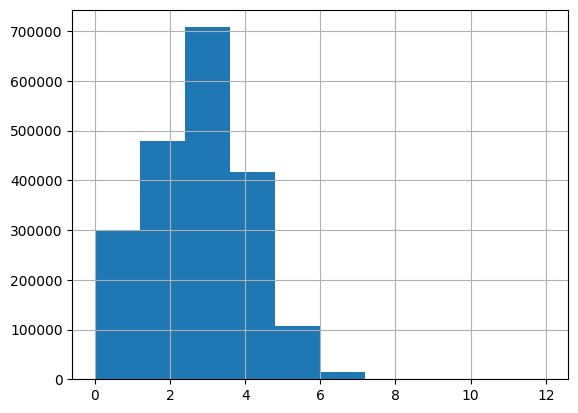

In [78]:
ddf['fk_grade'].hist(range=(0,12));

85% of the stories are at or below a Grade 4 reading level. 99% of them are at or below a Grade 6 level.

In [80]:
ddf.query('fk_grade <= 4')['text'].count() / len(ddf)

0.8508873110067892

In [97]:
ddf.query('fk_grade <= 6')['text'].count() / len(ddf)

0.9937878558431565

The story with the grade level of 74 has 750 words with 1033 syllables across only 4 sentences. The ratio of words per sentence is a staggering 187.5, which is greatly inflating the reading level.

In [87]:
hard_text = ddf.query('fk_grade > 74').iloc[0]['text']
hard_text

"Lily and Tom were playing in the kitchen. They liked to pretend they were chefs and make yummy food. They had a big pot and some spoons and bowls. They put water and salt and sugar and flour and carrots and apples and cheese and cookies and milk and eggs and bananas and pasta and bread and jam and butter and ketchup and mustard and chocolate and candy and nuts and beans and corn and peas and rice and meat and fish and cheese and yogurt and cereal and juice and tea and coffee and soda and water and ice and lemon and lime and orange and grape and cherry and strawberry and blueberry and raspberry and blackberry and cranberry and pineapple and mango and kiwi and coconut and melon and peach and plum and pear and apple and apricot and nectarine and grapefruit and pomegranate and fig and date and olive and avocado and tomato and cucumber and lettuce and spinach and kale and cabbage and broccoli and cauliflower and celery and carrot and onion and garlic and ginger and turmeric and parsley and

In [88]:
textstat.lexicon_count(hard_text), \
textstat.sentence_count(hard_text), \
textstat.syllable_count(hard_text)

(750, 4, 1033)

In [89]:
textstat.lexicon_count(hard_text) / textstat.sentence_count(hard_text), \
textstat.syllable_count(hard_text) / textstat.lexicon_count(hard_text)

(187.5, 1.3773333333333333)

A more reasonable story (although past K-12 grade levels) has 627 words across 20 sentences, resulting in a grade level of 15.5 (post-grad):

In [94]:
ddf.query('fk_grade > 12 and fk_grade < 16').iloc[0]['fk_grade']

15.5

In [90]:
hard_text = ddf.query('fk_grade > 12 and fk_grade < 16').iloc[0]['text']
hard_text

'Sam and Tom are friends. They like to play in the park. One day, they find a big sack near a tree. They wonder what is inside.\n\n"Let\'s open it and see!" Sam says.\n\n"OK, but we have to share what we find," Tom says.\n\nThey pull the sack to a quiet spot. They open it and see many shiny things. They are coins! Sam and Tom are very happy. They have never seen so many coins before.\n\n"Wow, we are so lucky!" Sam says.\n\n"Yes, we are! How many coins do you think there are?" Tom says.\n\nThey start to count the coins. But they have a problem. They do not know how to count very well. They only know how to count to ten. After ten, they get confused.\n\n"Ten, eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twenty-one, twenty-two, twenty-three, twenty-four, twenty-five, twenty-six, twenty-seven, twenty-eight, twenty-nine, thirty, thirty-one, thirty-two, thirty-three, thirty-four, thirty-five, thirty-six, thirty-seven, thirty-eight, thirty-nine,

In [91]:
textstat.lexicon_count(hard_text), \
textstat.sentence_count(hard_text), \
textstat.syllable_count(hard_text)

(627, 20, 989)

In [92]:
textstat.lexicon_count(hard_text) / textstat.sentence_count(hard_text), \
textstat.syllable_count(hard_text) / textstat.lexicon_count(hard_text)

(31.35, 1.5773524720893142)

11 stories have a grade level above 12.

In [96]:
ddf.query('fk_grade > 12')['text'].count()

11

## Final Thoughts

I am _elated_. I thought I was going to have to calculate reading levels by manually copy pasting text into one of the online calculators. For the `financial_phrasebank` dataset, that would be 2264 such operations. Instead, I can now use `textstat` as a baseline when comparing reading levels between original and LLM-generated simplified texts.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).